# Gesture Recognition
In this project, we will build a 3D Conv model that will be able to predict the 5 gestures correctly. 

In [1]:
#Import the following libraries
import numpy as np
import os
import datetime
import os
import cv2
import matplotlib.pyplot as plt 

We set the random seed so that the results don't vary drastically.

In [2]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.set_random_seed(30)

Using TensorFlow backend.


Read the folder names for training and validation. And set the `batch_size` here. Note that the batch size is set in such a way that you are able to use the GPU in full capacity. You can keep increasing the batch size until the machine throws an error.

In [3]:
train_doc = np.random.permutation(open('./Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('./Project_data/val.csv').readlines())
batch_size = 50 

### Data Augmentation Techniques

The techniques used for data augmentation are zoom-in, translation and flipping of the image. Each image from the training data is augmented. Data Augmention is performed for images of two dimensions.

In [4]:
def data_augmentation(folder_path):
    # Size of image
    y = 120
    z = 120

    # Read the image
    image_cv = cv2.imread(folder_path)

    # Convert to RGB
    image = cv2.cvtColor(image_cv, cv2.COLOR_BGR2RGB)          
                    
    # For faster processing, we will crop and resize the rectangular images
    if image.shape[0] < image.shape[1]:
        extra = (image.shape[1] - image.shape[0]) // 2
        cropped_image = image[:, extra:-extra]
    else:
        cropped_image = image

    # Resize the image to (120,120)
    resized_image = cv2.resize(cropped_image, (y,z))

    # For zoom-in: images are cropped and then resized
    cropped_image = resized_image[10:-10, 20:-20]
    cropped_resized_image = cv2.resize(cropped_image, (y, z))
        
    # Translation of the image
    height, width = resized_image.shape[:2]
    translation_height, translation_width = height / -10, width / 20
    T = np.float32([[1, 0, translation_width], [0, 1, translation_height]])
    translated_image = cv2.warpAffine(resized_image, T, (width,height))    

    # Image Flipping
    flipped_image = cv2.flip(resized_image, 1)

    # Plot the data augmented images
    plt.subplot(1,5,1)
    plt.imshow(image)
    plt.subplot(1,5,2)
    plt.imshow(resized_image)
    plt.subplot(1,5,3)
    plt.imshow(cropped_resized_image)
    plt.subplot(1,5,4)
    plt.imshow(translated_image)
    plt.subplot(1,5,5)
    plt.imshow(flipped_image)

Data Augmentation with 360x360 image



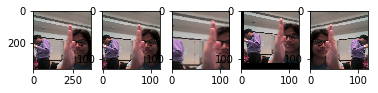

In [5]:
# Data Augmentation with 360x360 image
folder_path = './Project_data/train/WIN_20180907_15_35_09_Pro_Right Swipe_new/WIN_20180907_15_35_09_Pro_00042.png'
print('Data Augmentation with 360x360 image\n')
data_augmentation(folder_path)

Data Augmentation with 120x160 image



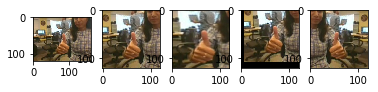

In [6]:
# Data Augmentation with 120x160 image
folder_path = './Project_data/train/WIN_20180925_17_32_52_Pro_Thumbs_Up_new/WIN_20180925_17_32_52_Pro_00015.png'
print('Data Augmentation with 120x160 image\n')
data_augmentation(folder_path)

## Generator
In the generator, first preprocess the images as the images are of 2 different dimensions as well as create a batch of video frames.

In [7]:
# Image Normalisation
def normalise_image(image):
    normalised_image = (image - np.mean(image)) / np.std(image)
    return normalised_image

In [8]:
# Yield batch data and labels
def yield_batch_data_labels(source_path, t, batch, batch_size, train = False): # Fetch one batch of data and labels
    img_idx = [i for i in range(0,30,2)] #create a list of image numbers you want to use for a particular video
    x = 15
    y = 120
    z = 120
    batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
    batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
    
    if train:
        batch_data_cropped,batch_labels_cropped = np.zeros((batch_size,x,y,z,3)),np.zeros((batch_size,5)) # For Data Augmentation
        batch_data_translated,batch_labels_translated = np.zeros((batch_size,x,y,z,3)),np.zeros((batch_size,5)) # For Data Augmentation
        batch_data_flipped,batch_labels_flipped = np.zeros((batch_size,x,y,z,3)),np.zeros((batch_size,5)) # For Data Augmentation
                                       
    for folder in range(batch_size): # iterate over the batch_size
        imgs = sorted(os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0])) # read all the images in the folder
        for idx,item in enumerate(img_idx): #  Iterate over the frames/images of a folder to read them in
            image_cv = cv2.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
            image = cv2.cvtColor(image_cv, cv2.COLOR_BGR2RGB)          
                    
            #crop the images and resize them 

            # For faster processing, we will crop and resize the rectangular images
            if image.shape[0] < image.shape[1]:
                extra = (image.shape[1] - image.shape[0]) // 2
                cropped_image = image[:, extra:-extra]
            else:
                cropped_image = image

            resized_image = cv2.resize(cropped_image, (y,z))

            batch_data[folder,idx,:,:,0] = normalise_image(resized_image[:,:,0]) #normalise and feed in the image
            batch_data[folder,idx,:,:,1] = normalise_image(resized_image[:,:,1]) #normalise and feed in the image
            batch_data[folder,idx,:,:,2] = normalise_image(resized_image[:,:,2]) #normalise and feed in the image
          
            # Batch Data for Data Augmentation
            if train:
                # Zoom-in
                cropped_image = resized_image[10:-10, 20:-20]
                cropped_resized_image = cv2.resize(cropped_image, (y, z))
        
                batch_data_cropped[folder,idx,:,:,0] = normalise_image(cropped_resized_image[:,:,0]) #normalise and feed in the image
                batch_data_cropped[folder,idx,:,:,1] = normalise_image(cropped_resized_image[:,:,1]) #normalise and feed in the image
                batch_data_cropped[folder,idx,:,:,2] = normalise_image(cropped_resized_image[:,:,2]) #normalise and feed in the image

                # Translation
                height, width = resized_image.shape[:2]
                translation_height, translation_width = height / -10, width / 20
                T = np.float32([[1, 0, translation_width], [0, 1, translation_height]])
                translated_image = cv2.warpAffine(resized_image, T, (width,height))        
            
                batch_data_translated[folder,idx,:,:,0] = normalise_image(translated_image[:,:,0]) #normalise and feed in the image
                batch_data_translated[folder,idx,:,:,1] = normalise_image(translated_image[:,:,1]) #normalise and feed in the image
                batch_data_translated[folder,idx,:,:,2] = normalise_image(translated_image[:,:,2]) #normalise and feed in the image
            
                # Flipping
                flipped_image = cv2.flip(resized_image, 1)

                batch_data_flipped[folder,idx,:,:,0] = normalise_image(flipped_image[:,:,0]) #normalise and feed in the image
                batch_data_flipped[folder,idx,:,:,1] = normalise_image(flipped_image[:,:,1]) #normalise and feed in the image
                batch_data_flipped[folder,idx,:,:,2] = normalise_image(flipped_image[:,:,2]) #normalise and feed in the image
            
        batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
        
        # Batch Labels for Data Augmentation
        if train:
            batch_labels_cropped[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            batch_labels_translated[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1

            #Labels are changed for flipped images
            if int(t[folder + (batch*batch_size)].strip().split(';')[2]) == 0:
                batch_labels_flipped[folder, 1] = 1
            elif int(t[folder + (batch*batch_size)].strip().split(';')[2]) == 1:
                batch_labels_flipped[folder, 0] = 1
            else:
                batch_labels_flipped[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            
            # Combining data with augmented data
            batch_data_augmented = np.concatenate([batch_data, batch_data_cropped, batch_data_translated, batch_data_flipped])
            batch_labels_augmented = np.concatenate([batch_labels, batch_labels_cropped, batch_labels_translated, batch_labels_flipped])
            
    if train:
        return batch_data_augmented, batch_labels_augmented
    else:
        return batch_data, batch_labels

In [9]:
def generator(source_path, folder_list, batch_size, ablation = None, train = False): # Generator Function
    print( 'Source path = ', source_path, '; batch size =', batch_size)
  
    if ablation is not None: # Subsets few images
        folder_list_shuffled = np.random.permutation(folder_list)
        folder_list = folder_list_shuffled[:ablation]
        
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(folder_list)//batch_size # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data, batch_labels = yield_batch_data_labels(source_path, t, batch, batch_size, train) 
            yield batch_data, batch_labels #yield the batch_data and the batch_labels

        # code for the remaining data points which are left after full batches
    
        if (len(folder_list)%batch_size != 0):
            batch_size = len(folder_list) % batch_size
            batch_data, batch_labels = yield_batch_data_labels(source_path, t, num_batches, batch_size, train) 
            yield batch_data, batch_labels #yield the batch_data and the batch_labels
            

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [10]:
curr_dt_time = datetime.datetime.now()
train_path = './Project_data/train'
val_path = './Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 30 # choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 30


## Model
Here we make theConv3D model to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [0]:
from keras.models import Sequential
from keras.layers import Dense, Flatten, BatchNormalization, Dropout
from keras.layers.convolutional import Conv3D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers


input_shape=(15,120,120,3)
num_classes = 5

model = Sequential()

# First Convolutional layer with Batch Normalisation followed by Pooling layer
model.add(Conv3D(8, kernel_size=(4,4,4), padding='same', activation='elu',
                 input_shape=input_shape))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(3,3,3)))

# Second Convolutional layer with Batch Normalisation followed by Pooling layer
model.add(Conv3D(16, kernel_size=(3,3,3), padding='same', activation='elu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2,2,2)))

# Third Convolutional layer with Batch Normalisation followed by Pooling layer
model.add(Conv3D(24, kernel_size=(3,3,3), padding='same', activation='elu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2,2,2)))

#Flatten Layers
model.add(Flatten())

# Ftrst Fully Connected Layer with Dropout and Batch Normalisation
model.add(Dense(128, activation='elu'))
model.add(Dropout(0.1))
model.add(BatchNormalization())

# Second Fully Connected Layer with Batch Normalisation
model.add(Dense(256, activation='elu'))
model.add(BatchNormalization())

# Softmax Layer
model.add(Dense(num_classes, activation='softmax'))

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [13]:
optimiser = optimizers.Adam() # optimizer 
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 15, 120, 120, 8)   1544      
_________________________________________________________________
batch_normalization_1 (Batch (None, 15, 120, 120, 8)   32        
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 5, 40, 40, 8)      0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 5, 40, 40, 16)     3472      
_________________________________________________________________
batch_normalization_2 (Batch (None, 5, 40, 40, 16)     64        
_________________________________________________________________
max_pooling3d_2 (MaxPooling3 (None, 2, 20, 20, 16)     0         
_________________________________________________________________
conv3d_3 (Conv3D)            (None, 2, 20, 20, 24)    

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [0]:
train_generator = generator(train_path, train_doc, batch_size, train=True)
val_generator = generator(val_path, val_doc, batch_size)

In [0]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, cooldown=1, verbose=1) # REducelronplateau
callbacks_list = [checkpoint, LR]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [0]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [17]:
history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0, use_multiprocessing = False)

Epoch 1/30
Source path =  ./Project_data/valSource path =   ./Project_data/train ; batch size = 50
; batch size = 50
14/14 [==============================] - 203s 14s/step - loss: 1.4525 - categorical_accuracy: 0.4563 - val_loss: 2.1320 - val_categorical_accuracy: 0.2400

Epoch 00001: val_loss improved from inf to 2.13197, saving model to model_init_2020-05-0316_01_44.550922/model-00001-1.47709-0.45626-2.13197-0.24000.h5
Epoch 2/30
14/14 [==============================] - 26s 2s/step - loss: 0.8826 - categorical_accuracy: 0.6635 - val_loss: 1.5408 - val_categorical_accuracy: 0.3300

Epoch 00002: val_loss improved from 2.13197 to 1.54076, saving model to model_init_2020-05-0316_01_44.550922/model-00002-0.88256-0.66346-1.54076-0.33000.h5
Epoch 3/30
14/14 [==============================] - 28s 2s/step - loss: 0.8499 - categorical_accuracy: 0.6937 - val_loss: 1.5475 - val_categorical_accuracy: 0.4100

Epoch 00003: val_loss did not improve from 1.54076
Epoch 4/30
14/14 [====================

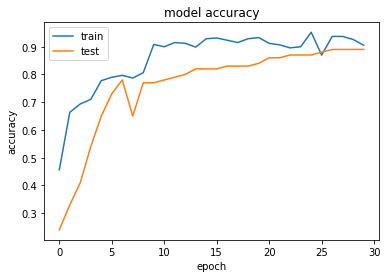

In [18]:
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Model Evalution
The model was tested on a batch of data of 5 gestures. 
#### **`Commenting the code for evaluation purpose.`**

In [22]:
# Read the test data
#test_path = '/content/drive/My Drive/test'
#test_doc = np.random.permutation(open('/content/drive/My Drive/test/test.csv').readlines())
#num_test_sequences = len(test_doc)
#print('# test sequences =', num_test_sequences)

# Setting batch size to 5
#batch_size = 5

# Generate the test data
#test_generator = generator(test_path, test_doc, batch_size)
#test_batch_data, test_batch_labels = next(test_generator)
#print('Test Batch Labels\n', test_batch_labels)

# test sequences = 5
Source path =  /content/drive/My Drive/test ; batch size = 5
Test Batch Labels
 [[0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0.]]


In [23]:
#from keras.models import load_model

# Load the model for evaluation
#test_results = load_model('/content/model_init_2020-05-0316_01_44.550922/model-00020-0.21283-0.93269-0.22741-0.84000.h5')

# Print batch labels (0-Left Swipe, 1-Right Swipe, 2-Stop, 3-Thumbs Down, Thumbs up
# The output labels can be checked with the test batch labels
#print(np.argmax(test_results.predict(test_batch_data[:,:,:,:,:]),axis=1))

[4 1 2 0 3]
